In [32]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import LassoCV , ElasticNetCV , RidgeCV
from sklearn.pipeline import Pipeline, FeatureUnion
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import cross_val_score, KFold, ShuffleSplit, GridSearchCV

from sklearn.ensemble import GradientBoostingRegressor as GBR
from xgboost import XGBRegressor as XGBR
# from xgboost import plot_importance
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.ensemble import RandomForestRegressor as RFR

from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA 
from sklearn.cross_decomposition import PLSRegression as  PLS
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler 
import statsmodels.api as sm

import pandas as pd
import numpy as np
import time

import pickle
import joblib

import plotly.express as px
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.io as pio
pd.options.plotting.backend = 'plotly'
init_notebook_mode(connected=True)
pio.renderers.default = "notebook_connected"

pd.set_option('display.max_row', 500)
pd.set_option('display.max_columns', 100)

## 기대 수명에 영향을 미치는 요인에 대한 회귀 분석
---
6조 고세영 & 김현진
<div>
    <div style="text-align:center";>
    <img src="../imgs/youngandjin_new.gif", style='width=150px; height:530px;'>
    </div>

## 1. 개요
---
- 프로젝트 주제 선정 동기
- 프로젝트 목적

### 프로젝트 주제 선정 동기
- Covid 19로 건강에 대한 관심 ↑
- 100세 시대를 코 앞에 두고 있는 요즘 <br>
  그냥 오래 사는 것보다 <strong>건강 하게 오래 사는 것</strong>이 중요
- 기대 수명이란? 
    - 특정 시기에 태어난 인구의 예상되는 수명 <br>
      (평균 수명: 특정 시기에 사망한 인구의 수명)
    - 세계 평균: 2000년 67세 ▷ 2018년 73세
    - 한국 평균: 2000년 76세 ▷ 2018년 83세
- 기대 수명을 늘리는 요인이 무엇인지 알아보자

### 프로젝트 목적
- 기대 수명과 연관된 요인 분석 <br>
  (선행 연구가 있는 사회/경제적 요인 + 예방 접종 여부, 교육 정도 등 기타 요인)
- 선형 회귀 기반 회귀 모델 공식화
- 개발도상국 등 기대 수명이 낮은 국가 대상, 기대 수명이 낮은 이유 및 수명 제고 방안 분석
<br>


### Dataset
- 출처: [Kaggle "Life-Expectancy(WHO)"](https://www.kaggle.com/kumarajarshi/life-expectancy-who)
- 개요: 2000~2015년 193개국의 기대수명 및 관련 요인 데이터셋
- 종속 변수(Target): 기대 수명
- 독립 변수(Features): 총 19개 / 5개 대분류로 나누어 분석
<div>
    <img src='../imgs/col_def.png', width = '550'>
</div>

### 결측치 찾기
원 데이터의 컬럼별 결측치 확인
- missingno
- bar chart 시각화
<br>
<div>
<img src="../imgs/data_missingno.png", width='900'/></div>
<br>
<div>
<img src="../imgs/data_missing.png", width='900'/></div>

### Feature 대분류별 연도별 추이
- 경제
<div>
<img src='../imgs/yearly_economy.png'/, width='1200'></div>

- 유병률
<div>
<img src='../imgs/yearly_illness.png'/, width='1300'></div>

- 예방접종
<div>
<img src='../imgs/yearly_vaccine.png'/, width='1300'></div>

- 기타
<div>
<img src='../imgs/yearly_others.png'/, width='1300'></div>

### Region별 대분류별 연도별 추이
- World bank 데이터 분류 기준 (총 7개)
<div>
<img src='../imgs/world-regions.png'/, width='1000'></div>

- 경제
<div>
<img src='../imgs/region_economy.png','style=width:2000px;'/></div>

- 사망률
<div>
<img src='../imgs/region_death.png'/, width='2000'></div>

- 유병률
<div>
<img src='../imgs/region_illness.png'/, width='2000'></div>

- 예방 접종
<div>
<img src='../imgs/region_vaccine.png'/, width='2000'></div>

- 기타
<div>
<img src='../imgs/region_others.png'/, width='2200'></div>

### 결측치 처리 방법
1. 국가 자체 삭제 (총 10개 삭제 -> 183개국)
    - 행이 1개인 국가
        - Monaco, Nauru, Dominica, Palau, Tuvalu, San Marino, Marshall Islands, St.Kitts and Nevis
    - 컬럼별 결측치 다수 존재하는 국가
        - Somalia, North Korea
2. 신규 데이터로 컬럼 전체 교체
    - World Bank의 국가별 데이터 참고
        - Percentage Expenditure, Infant death, GDP, Population
    - 일부 누락된 연도별 데이터 참고 (http://hdr.undp.org/en/content/download-data)
        - Income Composition of Resources

3. 결측치를 제외한 Mean값으로 대체<br>
    - 국가별 Mean값으로 대체
        - 국가 내 특정 연도만 결측치가 있는 경우
            - Total expenditure : 2015년 결측치 - 최근 2개년(2013~2014 평균)
            - Schooling, HepatitisB, Diphtheria : 결측치가 있는 연도를 제외한 나머지 평균<br><br>
    - Region별 연도별 Mean값으로 대체
        - 국가 전체 행이 모두 결측치인 경우
            - Schooling : Region별 평균으로 대체
<br><br>
4. 나라별 연도별 증감률 추이에 따라 처리
    - 다수의 1개 연도만 비어있는 국가는 나라별 연도별 증감률 추이에 맞춰 결측치 처리
        - Alcohol

### 결측치 ZERO!
<div>
<img src='../imgs/notnull_missingno.png'/ width='1200'></div>

## 2. EDA
---

### 변수 Heatmap
- Target인 기대 수명(Life expectancy)과 상관관계를 가진 Features 확인
- 양의 상관관계:  교육 정도(Schooling) 0.8, 자원의 소득 구성(Income composition of resources) 0.8
- 음의 상관관계: 영아 사망률(Infant deaths) -0.9, 성인 사망률(Adult mortality) -0.7

<div>
<img src="../imgs/heatmap_new.png", width='800'/></div>

#### 자원의 소득 구성(Income composition of resources) 이란?
- 소득과 자원의 가용성에 관한 인적 자원 개발 지수를 0~1 사이의 값으로 나타낸 것

    - <U>인적 자원 개발 지수 (HDI) = (1/3) x (소득지수) + (1/3) x (기대수명지수) + (1/3) × (교육지수)</U>
<div><br>
<img src="../imgs/human_development_index_HDI.png", width='900'/></div>

### 상관관계가 높은 Features 나라별 추이
- Schooling
- Income composition of resources
<img src='../imgs/schooling.png' style='height:370px; width:1000px;'/>
<img src='../imgs/hdi.png' style='height:370px; width:1000px;'/>

- Infant deaths
- Adult mortality
<img src='../imgs/infant_deaths.png' style='height:380px; width:1000px;'/>
<img src='../imgs/adult_mortality.png' style='height:380px; width:1000px;'/>

In [8]:
life_df = pd.read_csv("../datas/life_expectancy_data_fillna.csv")
life_df.columns = [cols.upper() for cols in life_df.columns.tolist()]

# Developing: 0, developed: 1
life_df["STATUS"] = [row.replace("Developing","0") for row in life_df["STATUS"].tolist()]
life_df["STATUS"] = [row.replace("Developed","1") for row in life_df["STATUS"].tolist()]
life_df["STATUS"] = [int(row) for row in life_df["STATUS"].tolist()]

life_df.reset_index(drop=True, inplace=True)
# GDP per capita 데이터 추가
GDP_PERCAP = pd.read_csv("../datas/worldbank_gdppercap.csv")
GDP_PERCAP = GDP_PERCAP.groupby('Country Code').mean()
GDP_PERCAP.drop(columns= ['2016', '2017','2018','2019','2020'],axis=1,inplace=True)

# life_df에 GDP per capita 컬럼 추가
life_df["GDP_PERCAP"] = [GDP_PERCAP.loc[life_df['COUNTRYCODE'][i]][str(life_df['YEAR'][i])] for i in range(len(life_df))]
life_df["GDP_PERCAP"].fillna(life_df["GDP"]/life_df["POPULATION"], inplace=True)

In [9]:
fig = px.scatter(life_df, x="GDP_PERCAP", y="LIFE_EXPECTANCY", size="POPULATION", color="REGION", animation_frame="YEAR",
           hover_name="COUNTRY", log_x=True, size_max=60, range_y=[40,90])
fig.show()

In [10]:
fig = px.scatter(life_df, x="GDP_PERCAP", y="LIFE_EXPECTANCY", animation_frame="YEAR", animation_group="COUNTRY",
           size="POPULATION", color="REGION", hover_name="COUNTRY", facet_col="REGION",
           log_x=True, size_max=60,range_y=[40,100])
fig.show()

In [11]:
fig = px.scatter(life_df, x="INCOME_COMPOSITION_OF_RESOURCES", y="LIFE_EXPECTANCY", animation_frame="YEAR", animation_group="COUNTRY",
           size="POPULATION", color="REGION", hover_name="COUNTRY", facet_col="REGION",
           size_max=50, range_x=[life_df["INCOME_COMPOSITION_OF_RESOURCES"].min(),life_df["INCOME_COMPOSITION_OF_RESOURCES"].max()], range_y=[50,90])
fig.show()

In [13]:
df = px.data.gapminder()

# 신생아(생후 28일) 사망자수 데이터 추가
death_0 = pd.read_csv("../datas/worldbank_neonatal_death.csv")
death_0 = death_0.groupby('Country Code').mean()
death_0.drop(columns= ['2016', '2017','2018','2019','2020'],axis=1,inplace=True)
# 1세 이하 사망자수 데이터 추가
death_1 = pd.read_csv("../datas/worldbank_1_death.csv")
death_1 = death_1.groupby('Country Code').mean()
death_1.drop(columns= ['2016', '2017','2018','2019','2020'],axis=1,inplace=True)
# 5~9세 사망자수 데이터 추가
death_5_9 = pd.read_csv("../datas/worldbank_5_9_death.csv")
death_5_9 = death_5_9.groupby('Country Code').mean()
death_5_9.drop(columns= ['2016', '2017','2018','2019','2020'],axis=1,inplace=True)
# 10~14세 사망자수 데이터 추가
death_10_14 = pd.read_csv("../datas/worldbank_10_14_death.csv")
death_10_14 = death_10_14.groupby('Country Code').mean()
death_10_14.drop(columns= ['2016', '2017','2018','2019','2020'],axis=1,inplace=True)
# 15~19세 사망자수 데이터 추가
death_15_19 = pd.read_csv("../datas/worldbank_15_19_death.csv")
death_15_19 = death_15_19.groupby('Country Code').mean()
death_15_19.drop(columns= ['2016', '2017','2018','2019','2020'],axis=1,inplace=True)

# life_df에 신규 컬럼 추가
life_df["0_YEARS_DEATHS"] = [death_0.loc[life_df['COUNTRYCODE'][i]][str(life_df['YEAR'][i])] for i in range(len(life_df))]
life_df["1_YEARS_DEATHS"] = [death_1.loc[life_df['COUNTRYCODE'][i]][str(life_df['YEAR'][i])] for i in range(len(life_df))]
life_df["5_9_YEARS_DEATHS"] = [death_5_9.loc[life_df['COUNTRYCODE'][i]][str(life_df['YEAR'][i])] for i in range(len(life_df))]
life_df["10_14_YEARS_DEATHS"] = [death_10_14.loc[life_df['COUNTRYCODE'][i]][str(life_df['YEAR'][i])] for i in range(len(life_df))]
life_df["15_19_YEARS_DEATHS"] = [death_15_19.loc[life_df['COUNTRYCODE'][i]][str(life_df['YEAR'][i])] for i in range(len(life_df))]

death_df = life_df[["REGION","COUNTRY","YEAR","LIFE_EXPECTANCY","0_YEARS_DEATHS", "1_YEARS_DEATHS", "5_9_YEARS_DEATHS", "10_14_YEARS_DEATHS", "15_19_YEARS_DEATHS", "ADULT_MORTALITY"]].copy()

In [14]:
fig = px.scatter(death_df, x="5_9_YEARS_DEATHS", y="LIFE_EXPECTANCY", animation_frame="YEAR", animation_group="COUNTRY",
           size="ADULT_MORTALITY", color="REGION", hover_name="COUNTRY", facet_col="REGION",
           log_x=True, size_max=20)
fig.show()

## 3. Data Preprocessing
---
- 범주형 데이터 처리
    - status: Developed, Developing
- GDP per capita 추가
- 상관계수가 높은 4개의 피처에 대한 아웃라이어 제거

#### 기대 수명(Life expectancy)과 높은 상관관계를 가지는 Features
- 양의 상관관계:  교육 정도(Schooling) 0.8, 자원의 소득 구성(Income composition of resources) 0.8
- 음의 상관관계: 영아 사망률(Infant deaths) -0.9, 성인 사망률(Adult mortality) -0.7

#### 다중공선성이 의심되는 컬럼
- Income composition of resources - Schooling 0.9 

### 이상치 제거
- 상위 5개 feature에 대한 region별 boxplot
<img src='../imgs/boxplot_top.png'/>

### Boxplot
- Schooling, Income composition of resources
<img src='../imgs/boxplot_schooling.png' style='height:400px; width:1000px;'/>
<img src='../imgs/boxplot_hdi.png' style='height:400px; width:1000px;'/>

- Infant deaths, Adult Mortality
<img src='../imgs/boxplot_adult.png' style='height:400px; width:1000px;'/>
<img src='../imgs/boxplot_infant.png' style='height:400px; width:1000px;'/>

### PCA 차원 축소
<p>적절한 n_components 개수 고민</p><br>
<img align='left' src='../imgs/elbow.png' style='height:450px; width:600px;'/>
<img align='left' src='../imgs/pca_df.png' style='height:270px; width:700px;'/>


<p>두개의 주성분을 잘 구분하는 feature</p><br>
<img align='left' src='../imgs/pca_2.png' style='height:450px; width:600px;'/>
<img align='left' src='../imgs/pca_country.png' style='height:450px; width:600px;'/>

## 4. Modeling
---
1. Dataset preprocessing
2. Model Pipeline & params
3. 결과 확인
4. 추가 데이터 predict

### Data preprocessing
---
- 범주형 데이터 처리
    - status: Developed, Developing
- GDP per capita 추가
- 상관계수가 높은 4개의 피처에 대한 아웃라이어 제거

In [2]:
# 상관계수가 높은 4개의 피처에 대한 아웃라이어 제거까지 전처리
original = pd.read_csv("../datas/life_expectancy_data_fillna.csv")

def add_feature(original, filename=None):
    path = "../datas/worldbank_"
    original.columns = [cols.upper() for cols in original.columns.tolist()]
    
    if not filename == None:
        df = pd.read_csv(f"{path}{filename}.csv").groupby('Country Code').mean()
        df.drop(columns=['2016', '2017','2018','2019','2020'], axis=1, inplace=True)
        col_name = filename.upper()
        original[col_name] = [df.loc[original['COUNTRYCODE'][i]][str(original['YEAR'][i])] 
                              for i in range(len(original))]
    return original

# GDP per capita 데이터 추가
original = add_feature(original, "gdppercap")

# Nan값 GDP/POP으로 대체
original["GDPPERCAP"].fillna(original["GDP"] / original["POPULATION"], inplace=True)
original.columns = [cols.upper() for cols in original.columns.tolist()]

# 범주형 데이터 처리 - status: Developed, Developing
original = pd.get_dummies(original, columns=['STATUS'], drop_first=True)

# 기대수명에 대한 나머지 feature들의 상관관계
corr_matrix = original.drop(['COUNTRYCODE','ISO3166','COUNTRY','YEAR', 'REGION','INCOMEGROUP'], axis=1).corr()
corr_matrix['LIFE_EXPECTANCY'].sort_values(ascending=False)

# LIFE_EXPECTANCY와 높은 상관관계를 가지는 피처 순 정렬
top_corr = abs(corr_matrix['LIFE_EXPECTANCY']).sort_values(ascending=False)[1:5]
top_features = top_corr.index.tolist()

# lower fence, upper fence
region = original['REGION'].unique().tolist()
fence = {}

for r in region:
    fence[r] = {}
    
    for i, f in enumerate(top_features):
        q1 = np.percentile(original[original['REGION'] == r][top_features[i]].values, 25)
        q3 = np.percentile(original[original['REGION'] == r][top_features[i]].values, 75)
        iqr = q3 - q1

        upper_fence = ((iqr * 1.5) + q3).round(3)
        lower_fence = (q1 - (iqr * 1.5)).round(3)
                
        fence[r][f] = [lower_fence, upper_fence]
   
    
# 이상치 제거
region = original['REGION'].unique().tolist()
drop_list, target_idx = [], []

for r in region:
    target_df = original[original['REGION'] == r]
    
    for f in top_features:
        drop_idx = target_df[(target_df[f] < fence[r][f][0]) | 
                  (target_df[f] > fence[r][f][1])].index.tolist()
        
        drop_list.append(drop_idx)

# 제거 대상 인덱스
target_idx = set([idx for lst in drop_list for idx in lst])
original = original.drop(target_idx, axis=0)

print('top features:', top_features)

top features: ['INFANT_DEATHS', 'SCHOOLING', 'INCOME_COMPOSITION_OF_RESOURCES', 'ADULT_MORTALITY']


### Pipeline & Params
---
- Linear Regression
- Decison Tree Regressor
- PCA + Linear Regression
- PLS Regression
- Gradient Boosting Regressor
- XGBoost Regressor
- Random Forest Regressor
- Support Vector Regressor
- Lasso
- Ridge
- Kernel Ridge Regression

In [3]:
pipe_linear = Pipeline([
                ('scl', StandardScaler()),
                ('poly', PolynomialFeatures()),
                 ('fit', LinearRegression())])
pipe_tree = Pipeline([
                ('scl', StandardScaler()),
                 ('fit', DTR())])
pipe_lasso = Pipeline([
                ('scl', StandardScaler()),
                ('poly', PolynomialFeatures()),
                 ('fit', Lasso(random_state=13))])
pipe_ridge = Pipeline([
                ('scl', StandardScaler()),
                ('poly', PolynomialFeatures()),
                 ('fit', Ridge(random_state=13))])
pipe_pca = Pipeline([
                ('scl', StandardScaler()),
                ('pca', PCA()), 
                 ('fit',LinearRegression())])
pipe_pls = Pipeline([
                ('scl', StandardScaler()),
                 ('fit', PLS())])
pipe_gbr = Pipeline([
                ('scl', StandardScaler()),
                 ('fit', GBR())])
pipe_xgbr = Pipeline([
                ('scl', StandardScaler()),
                 ('fit', XGBR(random_state=13))])
pipe_rfr = Pipeline([
                ('scl', StandardScaler()),
                 ('fit', RFR(random_state=13))])
pipe_svr = Pipeline([
                ('scl', StandardScaler()),
                 ('fit', SVR())])

pipe_KR = Pipeline([
                ('scl', StandardScaler()),
                 ('fit', KernelRidge())])

In [4]:
grid_params_linear = [{
    "poly__degree" : np.arange(1,3), 
    "fit__fit_intercept" : [True, False], 
}]
grid_params_tree = [{
  }]
grid_params_lasso = [{
    "poly__degree" : np.arange(1,3),
    "fit__tol" : np.logspace(-5,0,10) ,
    "fit__alpha" : np.logspace(-5,1,10) ,     
                     }]
grid_params_ridge = [{
    "poly__degree" : np.arange(1,3),
    "fit__alpha" : np.linspace(2,5,10) ,
    "fit__solver" : [ "cholesky","lsqr","sparse_cg"] ,
    "fit__tol" : np.logspace(-5,0,10) ,
                     }]
grid_params_pca = [{
    "pca__n_components" : np.arange(2,8)
}]
grid_params_pls = [{
    "fit__n_components" : np.arange(2,8)
}]

min_samples_split_range = [0.5, 0.7, 0.9]
max_depth = [2, 4, 6, 8]

grid_params_gbr =[{
    "fit__max_features" : ["sqrt","log2"] ,
    "fit__loss" : ["ls","lad","huber","quantile"] , 
    "fit__max_depth" : max_depth,
    "fit__min_samples_split" : min_samples_split_range ,
}]
grid_params_xgbr =[{
    "fit__max_features" : ["sqrt","log2"] ,
    "fit__loss" : ["ls","lad","huber","quantile"] , 
    "fit__max_depth" : max_depth,
    "fit__min_samples_split" : min_samples_split_range ,
}]
grid_params_rfr =[{
    
}]
grid_params_svr =[{
    "fit__kernel" : ["rbf", "linear"] ,
    "fit__degree" : [2, 3, 5] , 
    "fit__gamma" : np.logspace(-5,1,10) ,
}]
grid_params_KR =[{
    "fit__kernel" : ["rbf","linear"] , 
    "fit__gamma" : np.logspace(-5,1,10) ,
}]

In [5]:
pipe = [
    pipe_linear, pipe_tree, pipe_lasso, pipe_ridge, pipe_pca ,
    pipe_pls, pipe_gbr, pipe_xgbr, pipe_rfr, pipe_svr, pipe_KR 
]

params = [
    grid_params_linear, grid_params_tree, grid_params_lasso, grid_params_ridge, grid_params_pca,
    grid_params_pls, grid_params_gbr, grid_params_xgbr, grid_params_rfr, grid_params_svr, grid_params_KR
]
jobs = -1
cv = KFold(n_splits=5 , shuffle=True, random_state=13)
# cv = ShuffleSplit(n_splits=5 , test_size=0.2, random_state=13)

grid_dict = {
    0: 'Linear Regression', 
    1: 'Decison Tree Regressor',
    2: 'Lasso',
    3: 'Ridge',
    4: 'PCA Regression', 
    5: 'PLS Regression',
    6: "Gradient Boosting Regressor",
    7: "XGBoost Regressor",
    8: "Random Forest Regressor",
    9: "Support Vector Regressor",
    10: "Kernel Ridge Regression"
            }

### Model Fit
---
- GridSearchCV
- 결과 시각화

In [6]:
X = original.drop(['COUNTRYCODE','ISO3166','COUNTRY','YEAR','LIFE_EXPECTANCY','REGION','INCOMEGROUP'], axis=1)
y = original['LIFE_EXPECTANCY']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=13)

#### GridSerachCV로 modeling 및 model save

In [8]:
model_rmse = {}
model_r2 = {}
model_best_params = {}
model_fit_times = {}

for idx , (param , model) in enumerate(zip(params , pipe)):
    start_time = time.time()
    search = GridSearchCV(model, param, scoring  = "neg_mean_squared_error", 
                          cv=cv, n_jobs=jobs, verbose=-1 )
    search.fit(X_train , y_train)
    y_pred = search.predict(X_test)
    model_rmse[grid_dict.get(idx)] = np.sqrt(mse(y_test, y_pred))  
    model_r2[grid_dict.get(idx)] = r2(y_test, y_pred)  
    model_best_params[grid_dict.get(idx)] = search.best_params_
    model_fit_times[grid_dict.get(idx)] = time.time() - start_time
    joblib.dump(search, f'./models/{grid_dict.get(idx)}1.pkl') 
print("finish")

[19:28:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { loss, max_features, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


finish


#### Modeling results

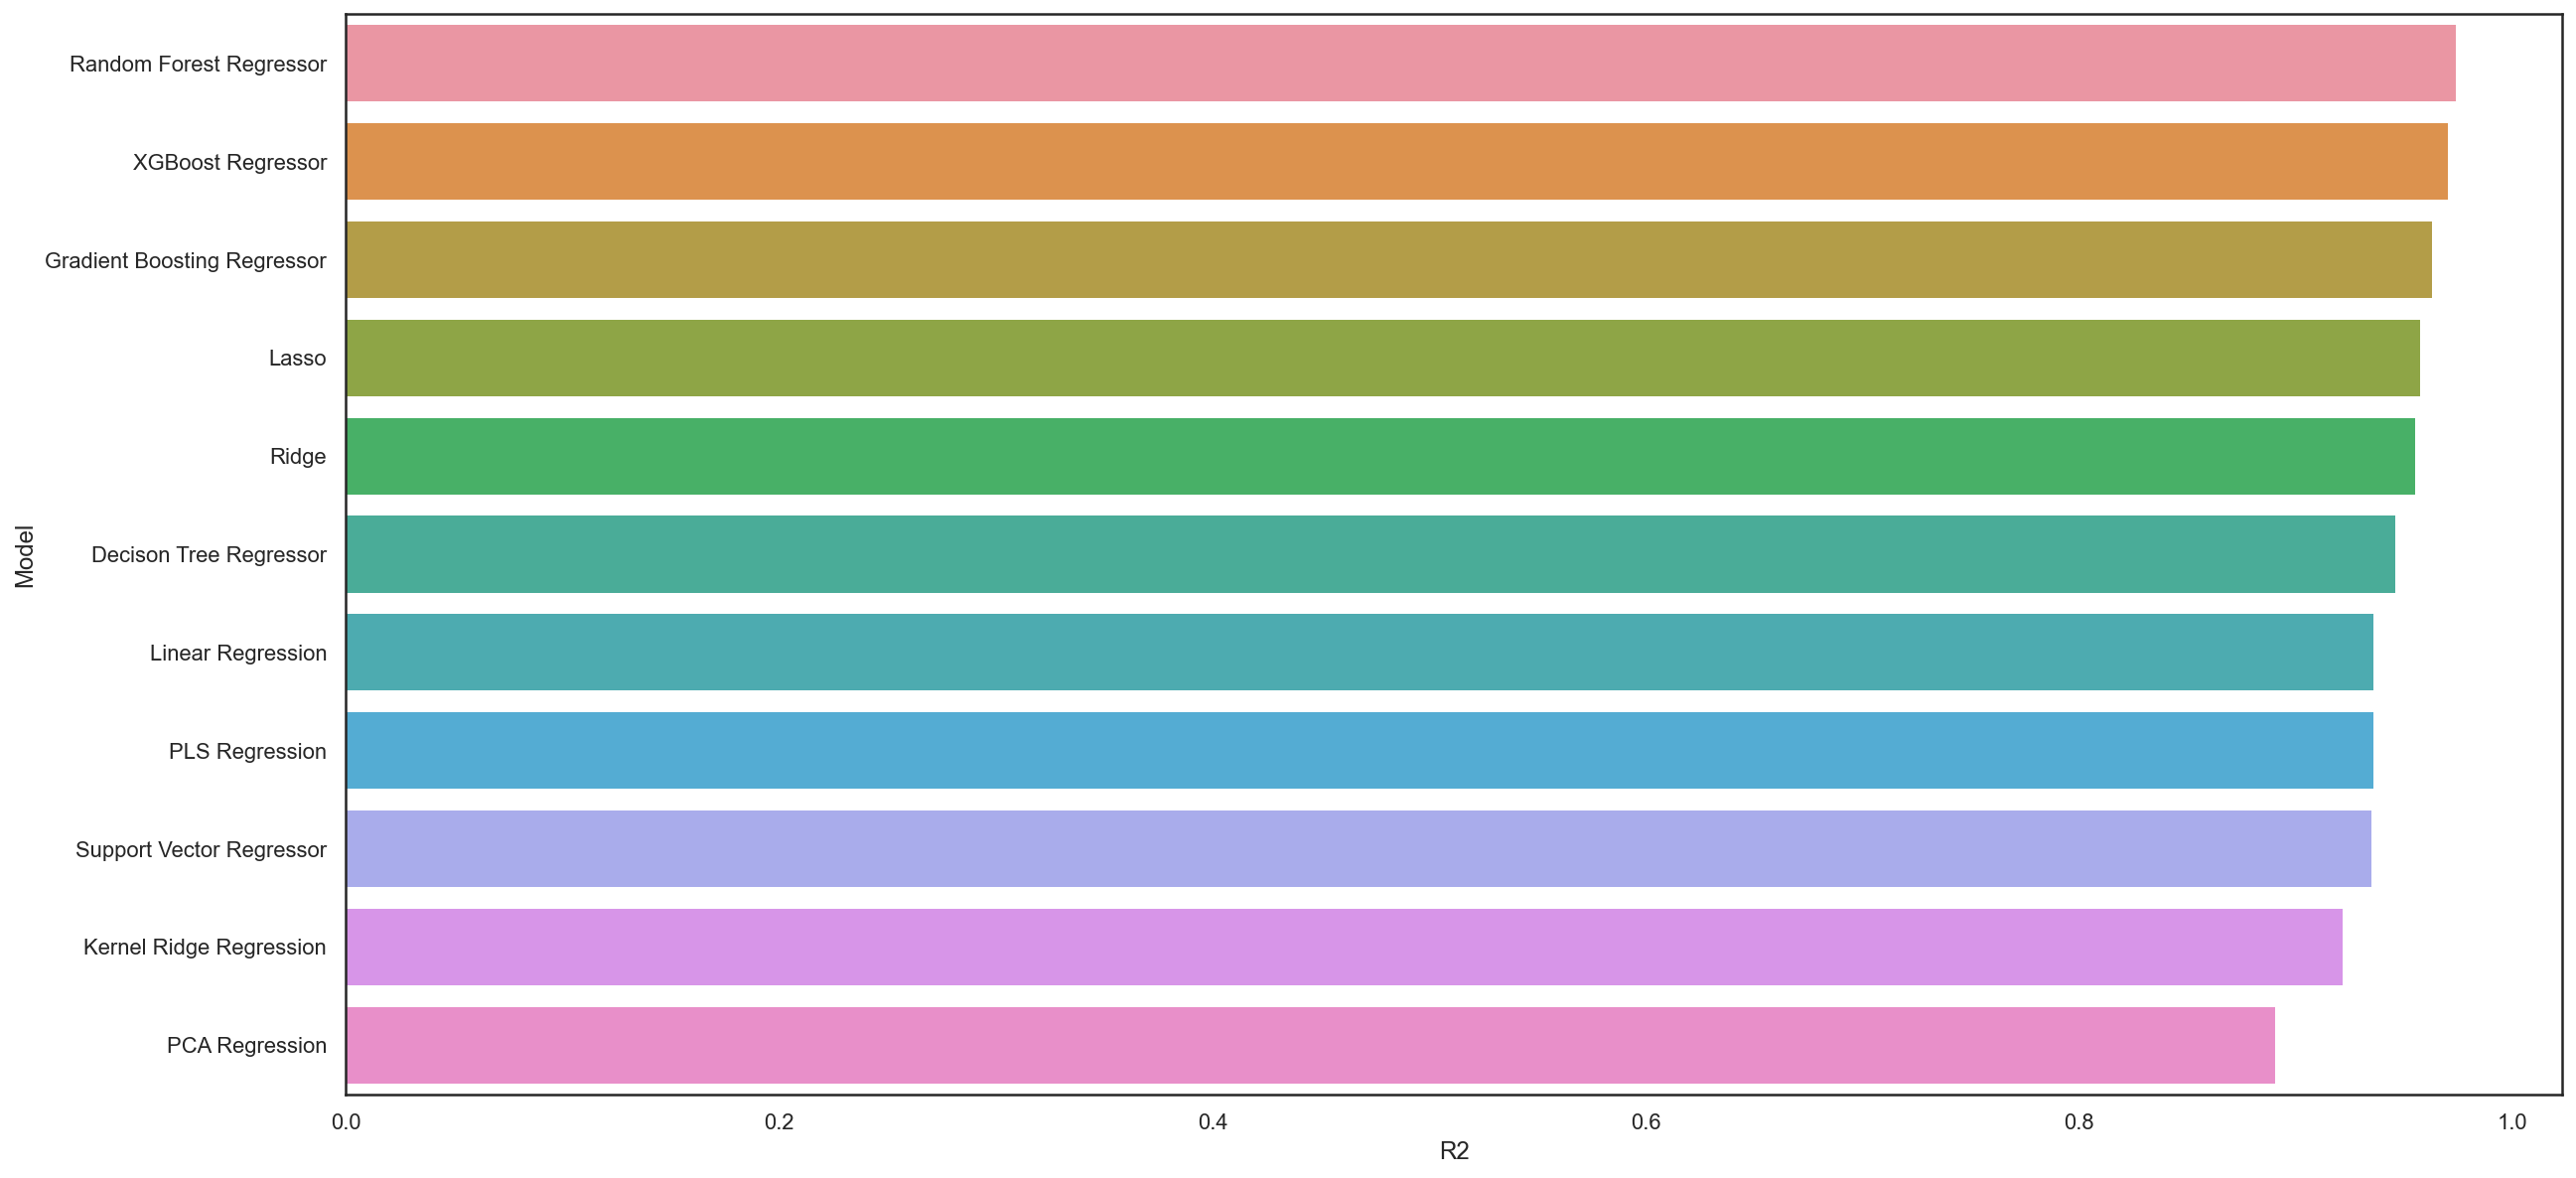

In [9]:
# Modeling 결과
fig ,ax = plt.subplots(figsize=(20, 10))
sns.set(font_scale = 2)
output = pd.DataFrame([model_r2.keys() , model_r2.values(), model_rmse.values(), model_fit_times.values()], index = ["Model","R2", "RMSE", "Fit_times"]).T
output.sort_values(["R2"], ascending= False ,inplace=True)
output["Fit_times"] = [abs(_) for _ in output["Fit_times"]]
ax = sns.barplot(y="Model", x="R2", data=output)
plt.show()

In [10]:
output['R2'] = [float(_) for _ in output['R2']]
output['RMSE'] = [float(_) for _ in output['RMSE']]
output

,Model,R2,RMSE,Fit_times
8,Random Forest Regressor,0.974162,1.548812,3.661124
7,XGBoost Regressor,0.970760,1.647630,157.729593
6,Gradient Boosting Regressor,0.963291,1.846109,24.433666
2,Lasso,0.957876,1.977602,17.936625
3,Ridge,0.955357,2.035870,17.769236
1,Decison Tree Regressor,0.946493,2.228826,0.119640
0,Linear Regression,0.936309,2.431698,1.811130
5,PLS Regression,0.936057,2.436519,0.232146
9,Support Vector Regressor,0.935315,2.450599,22.689313
10,Kernel Ridge Regression,0.922043,2.690293,4.555591


In [11]:
px.scatter(output,x='RMSE', y='R2', color='Model', labels='Model')

In [12]:
# Model().get_params().keys()로 가능한 params 조회 가능
model_best_params

{'Linear Regression': {'fit__fit_intercept': True, 'poly__degree': 1},
 'Decison Tree Regressor': {},
 'Lasso': {'fit__alpha': 0.021544346900318822,
  'fit__tol': 0.0016681005372000592,
  'poly__degree': 2},
 'Ridge': {'fit__alpha': 4.0,
  'fit__solver': 'lsqr',
  'fit__tol': 0.005994842503189409,
  'poly__degree': 2},
 'PCA Regression': {'pca__n_components': 7},
 'PLS Regression': {'fit__n_components': 7},
 'Gradient Boosting Regressor': {'fit__loss': 'ls',
  'fit__max_depth': 8,
  'fit__max_features': 'sqrt',
  'fit__min_samples_split': 0.5},
 'XGBoost Regressor': {'fit__loss': 'ls',
  'fit__max_depth': 8,
  'fit__max_features': 'sqrt',
  'fit__min_samples_split': 0.5},
 'Random Forest Regressor': {},
 'Support Vector Regressor': {'fit__degree': 2,
  'fit__gamma': 0.021544346900318822,
  'fit__kernel': 'rbf'},
 'Kernel Ridge Regression': {'fit__gamma': 0.004641588833612777,
  'fit__kernel': 'rbf'}}

### 추가 Predict
--- 

In [13]:
grid_dict = {
0: 'Linear Regression', 
1: 'Decison Tree Regressor',
2: 'Lasso',
3: 'Ridge',
4: 'PCA Regression', 
5: 'PLS Regression',
6: "Gradient Boosting Regressor",
7: "XGBoost Regressor",
8: "Random Forest Regressor",
9: "Support Vector Regressor",
10: "Kernel Ridge Regression"
        }

#### 2019년 한국 데이터

In [14]:
testset = pd.DataFrame(columns = original.columns)
new_dict = {'COUNTRYCODE': 'KOR',
            'YEAR':2019, 'STATUS_Developing': 0,
            'LIFE_EXPECTANCY':83,
            'GDP': 1646739.22, 
            'GDPPERCAP':31846.2, 
            'SCHOOLING':14, 
            'INFANT_DEATHS':3,
            'ADULT_MORTALITY':110,
            'INCOME_COMPOSITION_OF_RESOURCES':0.916,
            'POPULATION': 51709000,
           }
testset = testset.append(new_dict, ignore_index=True)
testset.fillna(original.mean(), inplace=True)
testset

,COUNTRYCODE,ISO3166,COUNTRY,YEAR,LIFE_EXPECTANCY,ADULT_MORTALITY,INFANT_DEATHS,ALCOHOL,PERCENTAGE_EXPENDITURE,HEPATITIS_B,...,GDP,POPULATION,THINNESS_1_19_YEARS,THINNESS_5_9_YEARS,INCOME_COMPOSITION_OF_RESOURCES,SCHOOLING,REGION,INCOMEGROUP,GDPPERCAP,STATUS_Developing
0,KOR,431.09992,NaN,2019,83,110,3,4.953657,5.970516,74.39988,...,1646739.22,51709000,7.745723,4.972702,0.916,14,NaN,NaN,31846.2,0


In [15]:
# 저장한 모델을 불러와 predict하는 함수
def model_predict(model_idx, test_df):
    saved_model = joblib.load(f"./models/{grid_dict.get(model_idx)}1.pkl")
    X_pr = test_df[X.columns]
    y_pr = test_df['LIFE_EXPECTANCY']

    y_pred = saved_model.predict(X_pr)
    print(f"{grid_dict.get(model_idx)} | 예측 기대 수명:{y_pred.mean().round(2)} / RMSE:, {np.sqrt(mse(y_pr, y_pred)).round(2)}")
    r2_score = r2(y_pr, y_pred)
    if r2_score is True:
        print("R2:", r2_score)

In [16]:
for idx, model_idx in enumerate(range(len(grid_dict))):
    model_predict(model_idx,testset)

Linear Regression | 예측 기대 수명:81.35 / RMSE:, 1.65
Decison Tree Regressor | 예측 기대 수명:77.5 / RMSE:, 5.5
Lasso | 예측 기대 수명:79.98 / RMSE:, 3.02
Ridge | 예측 기대 수명:78.79 / RMSE:, 4.21
PCA Regression | 예측 기대 수명:77.0 / RMSE:, 6.0
PLS Regression | 예측 기대 수명:80.9 / RMSE:, 2.1
Gradient Boosting Regressor | 예측 기대 수명:72.97 / RMSE:, 10.03
XGBoost Regressor | 예측 기대 수명:80.44999694824219 / RMSE:, 2.55
Random Forest Regressor | 예측 기대 수명:78.47 / RMSE:, 4.53
Support Vector Regressor | 예측 기대 수명:80.62 / RMSE:, 2.38
Kernel Ridge Regression | 예측 기대 수명:83.41 / RMSE:, 0.41


### 5. Model results visualization
----

In [17]:
data_df = pd.concat([original[X.columns], original['LIFE_EXPECTANCY']], axis=1)

X = data_df[X.columns]
y = data_df['LIFE_EXPECTANCY']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=13)

data_df['split'] = 'train'
data_df.loc[X_test.index, 'split'] = 'test'

In [18]:
# reg plot 함수
def reg_plotly(model_idx):
    model = joblib.load(f"./models/{grid_dict.get(model_idx)}1.pkl")
    model.fit(X_train, y_train)
    y_pred = model.predict(X)
    data_df['prediction'], data_df['y_test'], data_df['y_train']= y_pred, y_test, y_pred

    fig = px.scatter(
            data_df, x=data_df['LIFE_EXPECTANCY'], y=data_df['prediction'],
            marginal_y='histogram', color='split', title=f"{grid_dict.get(model_idx)} Model", 
            color_discrete_sequence=['red', 'cornflowerblue']) #mediumaquamarine

    fig.update_traces(histnorm='probability', selector={'type':'histogram'})

    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=y.min(), y0=y.min(),
        x1=y.max(), y1=y.max()
    )
    fig.update_layout(font_size=14, width=1000, height=600, template='plotly_white')
    fig.show()

In [19]:
reg_plotly(0)

In [20]:
reg_plotly(8)

## 5. 결론
---
- 특이한 사례들에 대한 EDA

### 기대수명 관련 EDA
- 기대수명 상위 / 하위 10% 국가간 비교
    - 기대수명과 높은 상관관계를 가지는 상위 4개 피처들의 수치 비교
- 기대수명 상위 10% 중 개발도상국
    - 개발도상국 평균대비 어떤 피처가 높은 수치를 보이는지
- 기대수명이 일정 수치를 유지하거나 하락하는 추세를 보이는 나라
    - 증감률 비교

#### 기대수명 상위 / 하위 10% 국가간 비교
- Life Expectancy
<img src='../imgs/lifex_status.png' style='height:450px; width:1000px;'/>

- Schooling
- Income composition of resources
<img src='../imgs/schooling_status.png' style='height:400px; width:1000px;'/>
<img src='../imgs/hdi_status.png' style='height:400px; width:1000px;'/>

#### 기대수명 상위 10% 중 개발도상국
- 60개의 row 중 France, Finland, Greece, Canada, Korea, Rep., Chile, Israel
<img src='../imgs/developing_vs.png' style='height:500px; width:1000px;'/>

#### 기대수명이 전년대비 7세 이상 하락을 보이는 나라
<p>- 총 23개국</p><br>
<img align='left' src='../imgs/fluct_plot.png' style='height:600px; width:850px;'/>
<img align='left' src='../imgs/fluct_five.png' style='height:600px; width:800px;'/>

#### 기대수명에 영향을 주는 요인?
<img align='left' src='../imgs/haiti_bar.png' style='height:550px; width:830px;'/>
<img align='left' src='../imgs/nigeria_bar.png' style='height:550px; width:830px;'/>

## 6. 번외
---
- 느낀점
- 아쉬운점